In [75]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [76]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


# Create Slice Manager Object

Users can request tokens with different Project and Scopes by altering project_name and scope parameters in the refresh call below.

In [77]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

## Orchestrator API example to query for available resources

In [78]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6/6 , core: 184/192 , ram: 1,512/1,536 G, disk: 9,560/9,600 G, unit: 3/3 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
	Site Interfaces:
UKY: { cpu: 6/6 , core: 188/192 , ram: 1,514/1,536 G, disk: 9,490/9,600 G, unit: 3/3 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 380/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
RENC
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/38

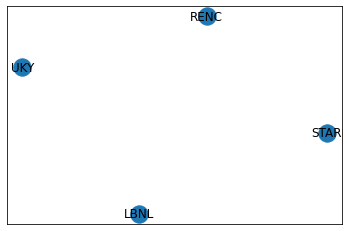

In [79]:
if status == Status.OK:
    advertised_topology.draw()

# Create Slice

In [152]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Shared Cards
n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')

# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/julin/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='iperf-test4', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "bfc90df0-4230-4dd6-bf77-9bc3ef5e9048",
    "lease_end": "2021-09-01 19:12:13",
    "pending_state": "None_",
    "reservation_id": "2fb2c2c5-be02-42dd-9386-e09b325d81f2",
    "reservation_state": "Unknown",
    "slice_id": "9765dd97-1ac7-4953-94e6-c68dbec0b0a8"
}, {
    "graph_node_id": "21917e97-d2dc-4f86-b7db-93bdce44562c",
    "lease_end": "2021-09-01 19:12:13",
    "pending_state": "None_",
    "reservation_id": "34359118-7015-4344-ae05-d8df62e87f33",
    "reservation_state": "Unknown",
    "slice_id": "9765dd97-1ac7-4953-94e6-c68dbec0b0a8"
}, {
    "graph_node_id": "26ed7c96-ebe2-4dab-93ac-6904b1b628bc",
    "lease_end": "2021-09-01 19:12:13",
    "pending_state": "None_",
    "reservation_id": "1962be61-72b4-4b77-a02d-22fe4be3ce08",
    "reservation_state": "Unknown",
    "slice_id": "9765dd97-1ac7-4953-94e6-c68dbec0b0a8"
}]


In [153]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

# Qurey slice

In [154]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "5d3a6d59-9e17-4f3e-900f-8e47f4e271d2",
    "lease_end": "2021-09-01 17:07:20",
    "slice_id": "32ba900c-151c-40a4-9e2c-6443fa31edc1",
    "slice_name": "iperf-test",
    "slice_state": "Dead"
}, {
    "graph_id": "1da9a5b8-6410-4bb9-bd11-fe74a818c565",
    "lease_end": "2021-09-01 17:17:06",
    "slice_id": "fd5d940b-b45e-48f6-81c4-22e9648a7f84",
    "slice_name": "iperf-test1",
    "slice_state": "Dead"
}, {
    "graph_id": "af3fef71-b08d-4464-88fc-add66baf5a55",
    "lease_end": "2021-09-01 17:49:51",
    "slice_id": "48bda246-a6d9-4a51-bdbc-e513261827ba",
    "slice_name": "iperf-test1",
    "slice_state": "Closing"
}, {
    "graph_id": "ccf0a2cd-f7c9-408d-ba5f-693c3fca670b",
    "lease_end": "2021-09-01 19:07:20",
    "slice_id": "fccfb08b-b205-40f1-9389-1c25fd72a13c",
    "slice_name": "iperf-test3",
    "slice_state": "Closing"
}, {
    "graph_id": "e99d5dd7-27ca-48a9-880c-78bfee9a5594",
    "lease_end": "2021-09-01 18:01:34",

# Query Slivers

In [156]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000193\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "bfc90df0-4230-4dd6-bf77-9bc3ef5e9048",
    "join_state": "NoJoin",
    "lease_end": "2021-09-01 19:12:13",
    "management_ip": "198.129.61.51",
    "name": "n1",
    "pending_state": "None_",
    "reservation_id": "2fb2c2c5-be02-42dd-9386-e09b325d81f2",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "9765dd97-1ac7-4953-94e6-c68dbec0b0a8"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000194\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"dis

In [157]:
server_ip = slivers[0].management_ip
server_ip

'198.129.61.51'

In [158]:
client_ip = slivers[1].management_ip
client_ip

'198.129.61.59'

In [159]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/home/julin/.ssh/id_rsa")
client_server = paramiko.SSHClient()
client_server.load_system_host_keys()
client_server.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client_server.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [160]:
# install iperf package
client_server.connect(server_ip,username='centos',pkey = key)
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

CentOS Linux 8 - AppStream                      6.7 MB/s | 8.8 MB     00:01    
CentOS Linux 8 - BaseOS                         3.6 MB/s | 5.6 MB     00:01    
CentOS Linux 8 - Extras                         5.1 kB/s |  10 kB     00:02    
Dependencies resolved.
 Package             Architecture  Version               Repository        Size
Installing:
 iperf3              x86_64        3.5-6.el8             appstream        100 k
Installing dependencies:
 lksctp-tools        x86_64        1.0.18-3.el8          baseos           100 k

Transaction Summary
Install  2 Packages

Total download size: 200 k
Installed size: 481 k
(1/2): lksctp-tools-1.0.18-3.el8.x86_64.rpm     1.0 MB/s | 100 kB     00:00    
(2/2): iperf3-3.5-6.el8.x86_64.rpm              254 kB/s | 100 kB     00:00    
--------------------------------------------------------------------------------
Total                                           174 kB/s | 200 kB     00:01     
CentOS Linux 8 - AppStream                     

In [168]:
stdin, stdout, stderr = client_server.exec_command('sudo ip addr add 198.129.61.51/24 dev eth1')
print("stdout", stdout.read().decode("utf-8"))
print("stderr", stderr.read().decode("utf-8"))

stdout 
stderr 


In [171]:
# server side run iperf
# print('iperf3 -s -B ' + server_ip)
#stdin, stdout, stderr = client_server.exec_command('iperf3 -s ' + server_ip + '&')
client_server.exec_command('iperf3 -s ' + server_ip)
#print ('')
#print (str(stdout.read(),'utf-8').replace('\\n','\n'))
#print (str(stderr.read(),'utf-8').replace('\\n','\n'))

(<paramiko.ChannelFile from <paramiko.Channel 7 (open) window=2097152 -> <paramiko.Transport at 0x9c176d60 (cipher aes128-ctr, 128 bits) (active; 2 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 7 (open) window=2097152 -> <paramiko.Transport at 0x9c176d60 (cipher aes128-ctr, 128 bits) (active; 2 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 7 (open) window=2097152 -> <paramiko.Transport at 0x9c176d60 (cipher aes128-ctr, 128 bits) (active; 2 open channel(s))>>>)

In [172]:
# clinet side
key = paramiko.RSAKey.from_private_key_file("/home/julin/.ssh/id_rsa")
client_client = paramiko.SSHClient()
client_client.load_system_host_keys()
client_client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client_client

In [173]:
# install iperf package
client_client.connect(client_ip,username='centos',pkey = key)
stdin, stdout, stderr = client_client.exec_command('sudo yum install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Last metadata expiration check: 0:02:31 ago on Tue 31 Aug 2021 07:16:07 PM UTC.
Package iperf3-3.5-6.el8.x86_64 is already installed.
Dependencies resolved.
Nothing to do.
Complete!




In [174]:
stdin, stdout, stderr = client_server.exec_command('sudo ip addr add 198.129.61.59/24 dev eth1')
print("stdout", stdout.read().decode("utf-8"))
print("stderr", stderr.read().decode("utf-8"))

stdout 
stderr RTNETLINK answers: File exists



In [175]:
stdin, stdout, stderr  = client_client.exec_command('iperf3 --get-server-output -c ' + server_ip)
print ('')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
print (str(stderr.read(),'utf-8').replace('\\n','\n'))



iperf3: error - unable to connect to server: Connection timed out



# Delete Slice

In [141]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
